# Импорт библиотек

In [1]:
%pip install category_encoders

In [33]:
import category_encoders as ce
from datetime import datetime
from itertools import chain
from collections import Counter
from re import split
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import sklearn.preprocessing as sklp
import sklearn.model_selection as skms
import sklearn.metrics as skmtr
import sklearn.linear_model as sklm
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Загрузка и обработка данных

## Общая подготовка датасетов

In [3]:
file_id = "1_sYqRu_in8ZBzh7LcnJl1yK7cGVNzDpa"
url = f"https://drive.google.com/uc?id={file_id}"
output = "metacritic_games.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1_sYqRu_in8ZBzh7LcnJl1yK7cGVNzDpa
To: /content/metacritic_games.csv
100%|██████████| 14.4M/14.4M [00:00<00:00, 98.7MB/s]


'metacritic_games.csv'

In [4]:
file_id = "1Fa9i118HY2GMswSKENrv6SCZpWnsnTqW"
url = f"https://drive.google.com/uc?id={file_id}"
output = "metacritic_reviews.csv"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Fa9i118HY2GMswSKENrv6SCZpWnsnTqW
From (redirected): https://drive.google.com/uc?id=1Fa9i118HY2GMswSKENrv6SCZpWnsnTqW&confirm=t&uuid=2ed1ff6a-8cf0-439a-9e70-7b706d666dae
To: /content/metacritic_reviews.csv
100%|██████████| 280M/280M [00:03<00:00, 79.8MB/s]


'metacritic_reviews.csv'

Для начала обработаем основной датасет. Уберём ненужные столбцы и удалим строки с пропусками данных. Затем переведём значения userscore в целочисленный диапазон от 0 до 100 и переформируем колонку release date в year типа int.

In [5]:
metacritic_games = pd.read_csv('metacritic_games.csv', sep=',')

cols_to_drop = ['esrb_rating', 'ESRBs', 'num_players', 'user_reviews', 'critic_reviews', 'summary', 'metascore']
metacritic_games = metacritic_games.drop(columns=cols_to_drop)
new_columns = ['id', 'title', 'year', 'genre', 'platform', 'developer', 'userscore']
metacritic_games.columns = new_columns
metacritic_games = metacritic_games.drop(columns='id')

metacritic_games['year'] = pd.to_datetime(metacritic_games['year'], format="%b %d, %Y", errors='coerce')
metacritic_games['userscore'] = metacritic_games['userscore'].replace('tbd', None)

metacritic_games['genre'] = metacritic_games['genre'].replace(' ', None)

metacritic_games = metacritic_games.dropna()

metacritic_games['userscore'] = metacritic_games['userscore'].astype(float)
metacritic_games['year'] = metacritic_games['year'].apply(lambda x: x.year).astype(int)

metacritic_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17929 entries, 0 to 19316
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      17929 non-null  object 
 1   year       17929 non-null  int64  
 2   genre      17929 non-null  object 
 3   platform   17929 non-null  object 
 4   developer  17929 non-null  object 
 5   userscore  17929 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 980.5+ KB


## Обработка категориальных признаков

Выведем количества уникальных значений для категориальных признаков:

In [6]:
print(f"Unique developer count: {len(metacritic_games['developer'].unique())}")
print(f"Unique platform count: {len(metacritic_games['platform'].unique())}")
print(f"Unique genres combination count: {len(metacritic_games['genre'].unique())}")
print(f"Unique year count: {len(metacritic_games['year'].unique())}")

Unique developer count: 4376
Unique platform count: 22
Unique genres combination count: 2151
Unique year count: 28


Из соображений безопасности создадим рабочую копию датасета:

In [7]:
prediction_df = metacritic_games.copy()

Для столбца platform  подойдет One-Hot Encoder, так как уникальных значений платформ всего 22, то есть мы не очень сильно увеличим размерность данных.

Аналогично с годом выпуска игр

In [8]:
prediction_df = pd.get_dummies(prediction_df, columns=['platform'], drop_first=True)
prediction_df = pd.get_dummies(prediction_df, columns=['year'], drop_first=True)

Посмотрим на распределение количества выпущенных разработчиками игр:

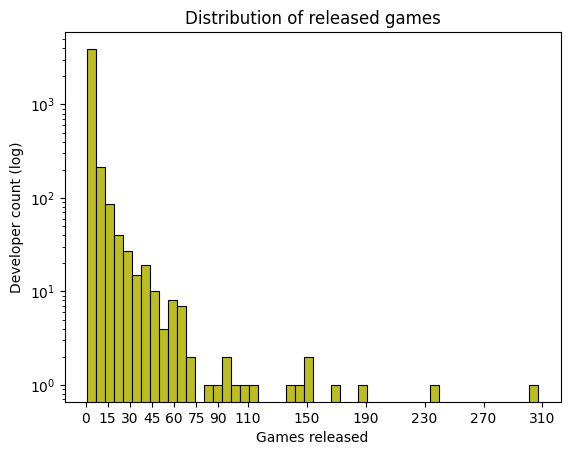

In [9]:
df_counts = prediction_df['developer'].value_counts().reset_index()
plt.hist(df_counts['count'], bins=50, color='tab:olive', linewidth=0.8, edgecolor='black')
plt.xticks(list(np.arange(0, 100, 15)) + list(np.arange(110, 350, 40)))
plt.yscale('log')
plt.xlabel("Games released")
plt.ylabel("Developer count (log)")
plt.title("Distribution of released games")
plt.show()

Сделаем следующее: выделим несколько групп студий по количеству выпущенных игр и запишем для них в столбец developer название группы.

In [10]:
prediction_df['count'] = prediction_df['developer'].map(prediction_df['developer'].value_counts())
prediction_df.loc[prediction_df['count'] <= 75, 'developer'] = 'other0'
prediction_df.loc[prediction_df['count'] <= 50, 'developer'] = 'other1'
prediction_df.loc[prediction_df['count'] <= 40, 'developer'] = 'other2'
prediction_df.loc[prediction_df['count'] <= 30, 'developer'] = 'other3'
prediction_df.loc[prediction_df['count'] <= 20, 'developer'] = 'other4'
prediction_df.loc[prediction_df['count'] <= 15, 'developer'] = 'other5'
prediction_df.loc[prediction_df['count'] <= 10, 'developer'] = 'other6'
prediction_df.loc[prediction_df['count'] <= 5, 'developer'] = 'other7'
prediction_df.loc[prediction_df['count'] <= 3, 'developer'] = 'other8'
prediction_df.loc[prediction_df['count'] <= 2, 'developer'] = 'other9'
prediction_df.loc[prediction_df['count'] <= 1, 'developer'] = 'other10'
prediction_df = prediction_df.drop(columns='count')

print(f"Unique developer count: {len(prediction_df['developer'].unique())}")

Unique developer count: 26


Теперь у нас всего 26 уникальных значений в столбце developer, 15 из которых отвечают за самые крупные студии, тогда как 11 соответствуют выделенным группам разработчиков.

In [11]:
prediction_df = pd.get_dummies(prediction_df, columns=['developer'], drop_first=True)

Подготовим столбец genre. Каждой игре соответствует несколько жанров, поэтому необходимо обработать данные. Убедимся, что названия жанров в ячейках не повторяются и не содержат лишних символов. Затем объединим их в строки с разделителем, чтобы применить аналог OHE.

In [12]:
prediction_df['genre'] = prediction_df['genre'].apply(lambda x: list(set(split(r'[ ,]{2,}', x))))
prediction_df['genre'] = prediction_df['genre'].apply(lambda x: list(map(lambda x: x.strip(','), x)))
prediction_df['genre'] = prediction_df['genre'].apply(lambda x: '|'.join(x))
genre_OHE_df = prediction_df['genre'].str.get_dummies(sep='|')
genre_OHE_df.head(5)

,2D,3D,4X,Action,Action Adventure,Action RPG,Adventure,Alternative,Application,Arcade,...,Virtual,Virtual Life,Visual Novel,Volleyball,WWI,WWII,Wakeboarding,Wargame,Western-Style,Wrestling
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Добавим полученные столбцы в датасет:

In [13]:
prediction_df = prediction_df.join(genre_OHE_df)

Выведем полученный датасет:

In [14]:
prediction_df

,title,genre,userscore,platform_DS,platform_Dreamcast,platform_Game Boy Advance,platform_GameCube,platform_Nintendo 64,platform_PC,platform_PSP,...,Virtual,Virtual Life,Visual Novel,Volleyball,WWI,WWII,Wakeboarding,Wargame,Western-Style,Wrestling
0,Burnout 3: Takedown,Racing|Arcade|Driving,7.7,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,Jet Grind Radio,Action|Platformer|3D,8.3,False,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,Metal Gear Solid 4: Guns of the Patriots,Modern|Action Adventure|General,8.8,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,Tom Clancy's Splinter Cell Chaos Theory,Modern|Action Adventure,9.1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,Call of Duty: Modern Warfare 2,Action|First-Person|Modern|Shooter|Arcade,6.6,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19312,Family Party: 30 Great Games Obstacle Arcade,Miscellaneous|Party|Party / Minigame,2.5,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
19313,Ride to Hell: Retribution,Racing|Motocross|Action Adventure|General|Mode...,1.4,False,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
19314,Far Cry 5: Lost on Mars,Action|Shooter|Arcade|First-Person,4.5,False,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
19315,Smash T.V.,Action|Static|Shooter|Top-Down|Shoot-'Em-Up,8.3,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


# Модель линейной регрессии

Сделаем копию обработанного датасета и выделим матрицу признаков и столбец таргетов. Пока что отделим от датасета строчки с уникальным значением таргета.

In [15]:
X = prediction_df.copy()

X = X.drop(columns=['title', 'genre'])

unique = X[X['userscore'].map(X['userscore'].value_counts()) == 1]
X = X[~X.index.isin(unique.index)]

unique = unique.reset_index(drop = True)
X = X.reset_index(drop = True)

y = X['userscore'] # target column
X = X.drop(columns='userscore') # feature matrix

Разделим датасет на обучающую и тестовую выборки. Используем параметр stratify, чтобы распределение данных в обучающей и тестовой выборках были одинаковыми. Добавим к обучающей выборке уникальные строчки.

In [16]:
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

X_train = pd.concat([X_train, unique.drop(columns='userscore')])
y_train = pd.concat([y_train, unique['userscore']])
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

Проведем стандартизацию данных: удалим среднее и масштабируем дисперсию к единице.


In [17]:
scaler = sklp.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучим линейную модельи посчитаем ошибки на обучающей и тестовой выборках:

In [18]:
model = sklm.LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Errors on test data:')

mape_test = skmtr.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mae_test:.6f}")

rmse_test = np.sqrt(skmtr.mean_squared_error(y_test, y_pred))
print(f"RMSE: {mse_test:.6f}")

y_pred_train = model.predict(X_train)

print('Errors on train data:')

mape_train = skmtr.mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE: {mae_train:.6f}")

rmse_train = np.sqrt(skmtr.mean_squared_error(y_train, y_pred_train))
print(f"RMSE: {mse_train:.6f}")

Errors on test data:
MAPE: 0.176885
RMSE: 1.259128
Errors on train data:
MAPE: 0.176014
RMSE: 1.238280


Видим довольно высокую ошибку. Изобразим точность предсказаний:

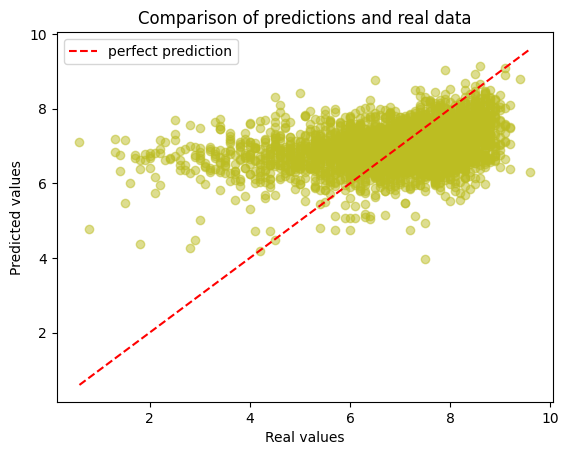

In [19]:
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:olive')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='perfect prediction')
plt.legend()
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison of predictions and real data")
plt.show()

Модель плохо обучилась: чаще всего она предсказывает значения в интервале $[60, 80]$. Проверим распределения таргетов:

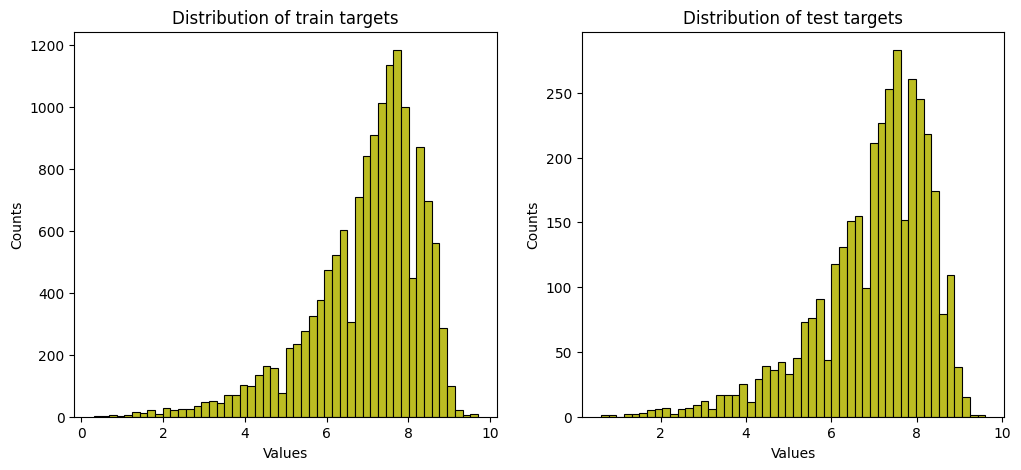

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(y_train, bins=50, color='tab:olive', linewidth=0.8, edgecolor='black')
axes[0].set_title("Distribution of train targets")
axes[0].set_xlabel("Values")
axes[0].set_ylabel('Counts')

axes[1].hist(y_test, bins=50, color='tab:olive', linewidth=0.8, edgecolor='black')
axes[1].set_title("Distribution of test targets")
axes[1].set_xlabel("Values")
axes[1].set_ylabel('Counts')

plt.show()

В данных имеется существенный перекос, то есть большинство игр имеют рейтинг в диапазоне от 60 до 80. Из-за этого обученная модель имеет плохую обобщающую способность.

# Модель решающего дерева

Попробуем нелинейные модели, которые способны выявить более сложные зависимости в данных. Для начала снова разделим выборки.

In [29]:
X = prediction_df.copy()

X = X.drop(columns=['title', 'genre'])

unique = X[X['userscore'].map(X['userscore'].value_counts()) == 1]
X = X[~X.index.isin(unique.index)]

unique = unique.reset_index(drop = True)
X = X.reset_index(drop = True)

y = X['userscore'] # target column
X = X.drop(columns='userscore') # feature matrix

X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

X_train = pd.concat([X_train, unique.drop(columns='userscore')])
y_train = pd.concat([y_train, unique['userscore']])
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

Теперь обучим решающее дерево. Подберем наилучшую его глубину через GridSearchCV и посмотрим на ошибку.

In [27]:
max_depth_values = {'max_depth': np.arange(1, 15, 1)}

search = GridSearchCV(DecisionTreeRegressor(),
                     max_depth_values,
                     scoring='neg_root_mean_squared_error',
                     cv=10)

print('Лучшее значение max_depth:', search.fit(X_train, y_train).best_params_)

Лучшее значение max_depth: {'max_depth': 8}


In [32]:
tree_regressor = DecisionTreeRegressor(max_depth=8)
tree_regressor.fit(X_train, y_train)

y_pred = tree_regressor.predict(X_test)

print('Errors on test data:')

mape_test = skmtr.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_test:.6f}")

rmse_test = np.sqrt(skmtr.mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_test:.6f}")

y_pred_train = model.predict(X_train)

print('Errors on train data:')

mape_train = skmtr.mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE: {mape_train:.6f}")

rmse_train = np.sqrt(skmtr.mean_squared_error(y_train, y_pred_train))
print(f"RMSE: {rmse_train:.6f}")

Errors on test data:
MAPE: 0.184493
RMSE: 1.309555
Errors on train data:
MAPE: 0.200137
RMSE: 1.396596


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


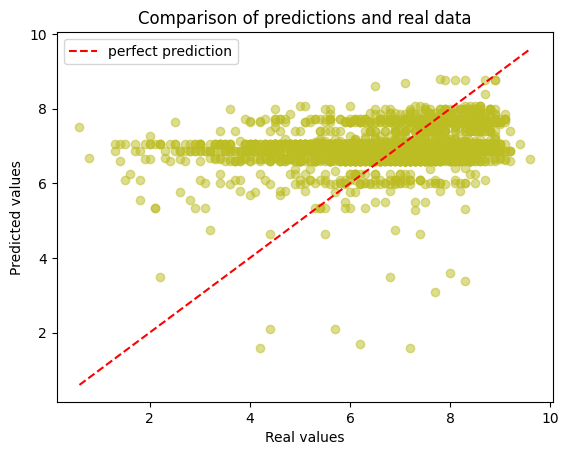

In [31]:
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:olive')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='perfect prediction')
plt.legend()
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison of predictions and real data")
plt.show()

Видим, что на этих данных дерево обучилось даже хуже линейной модели. Попробуем использовать модель градиентного бустинга. Благодаря итерационности процесса, градиентный бустинг должен улучшить результат одного дерева. Значения гиперпараметров были подобраны локально ввиду низких вычислительных скоростей google colab.

In [37]:
gb_regr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.025, max_depth=11, max_features='log2', random_state=42)

gb_regr.fit(X_train, y_train)

y_pred = gb_regr.predict(X_test)

print('Errors on test data:')

mape_test = skmtr.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_test:.6f}")

rmse_test = np.sqrt(skmtr.mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_test:.6f}")

y_pred_train = model.predict(X_train)

print('Errors on train data:')

mape_train = skmtr.mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE: {mape_train:.6f}")

rmse_train = np.sqrt(skmtr.mean_squared_error(y_train, y_pred_train))
print(f"RMSE: {rmse_train:.6f}")

Errors on test data:
MAPE: 0.166943
RMSE: 1.208704
Errors on train data:
MAPE: 0.200137
RMSE: 1.396596


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


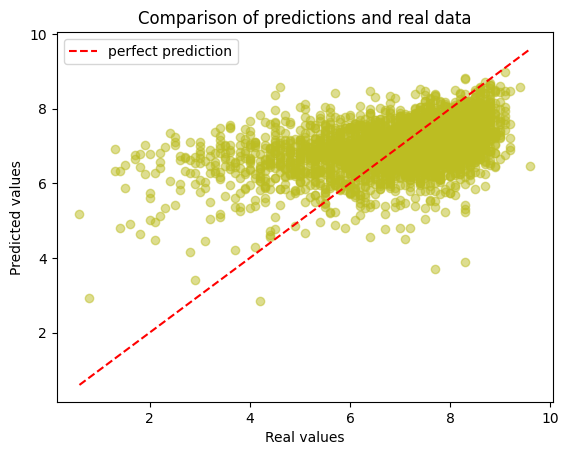

In [35]:
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:olive')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='perfect prediction')
plt.legend()
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison of predictions and real data")
plt.show()

Качество предсказаний модели улучшилось, но осовная проблема осталась той же. Можно сделать вывод, что используемые данные слишком плохо распределены. Кроме того, так как все используемые признаки категориальны, зависимости довольно условны, что опять же не позволяет нам обучить модель правильно.

Теперь имеет смысл добавить к признакам отзывы об игре и проверить, улучшит ли это предсказания моделей.